# Get Weather Demo

In [1]:
import sys
from datetime import datetime
import pandas as pd
sys.path.append('..')
from WeatherFetcher import WeatherFetcher

The WeatherFetcher class requires a pandas DataFrame object with column titles 
'Latitude', 'Longitude', and 'Vintage Year', indicating the coordinates and year 
that the originating grapes were harvested.

In this example, we are going to request historical weather data for a 2019 Napa
Valley wine (located at 38.4274 latitude, 122.3943 longitude).

In [2]:
data = pd.DataFrame(
    [[45.35, -123.0667, 'sonoma', 2005],
    [45.35, -123.0667, 'sonoma', 2007]],
    columns=['latitude', 'longitude', 'region', 'vintage']
    )
data

,latitude,longitude,region,vintage
0,45.35,-123.0667,sonoma,2005
1,45.35,-123.0667,sonoma,2007


Now we will initailize a WeatherFetcher object that will organize the requested
data

In [3]:
wf = WeatherFetcher(data = data)
wf.query_weather()
wf.clean_weather_data()
wf.filter_weather_data()

Data has been pulled for sonoma (2005 - 2007)

Data has been cleaned for sonoma in 0.8008 seconds

Data filtered for sonoma (2005)
Data filtered for sonoma (2007)


Let's look at the output

In [6]:
wf.output['sonoma-2007']

,time,tavg,tmin,tmax,prcp,snow,wspd,pres
0,2007-03-01,4.5,1.7,7.2,0.731250,0.0,10.9,1.006366
1,2007-03-02,7.4,4.4,10.0,0.731250,0.0,12.1,1.009919
2,2007-03-03,10.3,7.2,13.9,0.731250,0.0,8.8,1.016926
3,2007-03-04,9.2,4.0,15.0,0.000000,0.0,3.9,1.003885
4,2007-03-05,11.9,6.7,18.3,0.000000,0.0,4.5,1.007353
...,...,...,...,...,...,...,...,...
236,2007-10-27,11.4,3.9,18.3,0.000000,0.0,12.1,1.009425
237,2007-10-28,7.1,0.6,16.7,0.000000,0.0,0.7,1.011103
238,2007-10-29,8.4,2.8,13.3,0.000000,0.0,2.0,1.008833
239,2007-10-30,8.0,2.8,14.4,0.000000,0.0,2.4,1.012682


Let's check to see when pressure starts to be faithfully documented

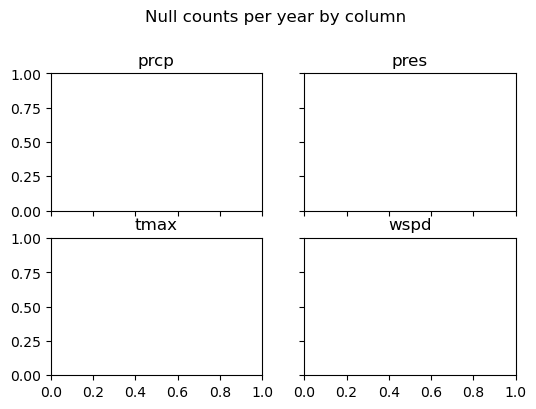

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Grab a copy of the data
df = wf.output['sonoma-2007']

# Start a 2,2 subplot
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex='all', sharey='all')
fig.dpi = 100
fig.figsize = (4, 2) 
for i, filter in enumerate(['prcp', 'pres', 'tmax', 'wspd']):
    filtered_df = df.loc[df[filter].isna()]
    dates = filtered_df.index
    dates = dates.values.astype('datetime64[Y]').astype('int') + 1970
    # print(dates)
    ax =sns.histplot(dates, ax = axs[int(math.floor(i/2)), i % 2])
    ax.set_title(filter)
title = fig.suptitle('Null counts per year by column', y = 1.04)

Looks like the data doesn't capture certain columns faithfully until 2016. This
will have to be considered, or transformations will neede to be made.

Let's save the data for setting up the models

# Data Cleaning
1. Fill null snow and rain with monthly average / days
2. Nixing wind direction, wind gust, tsun columns
3. Convert pressure to ATM
4. Fill null pressure and wind speeds with monthly averages over all available years

In [ ]:
# Remove superfluous columns
d = df.drop(columns=['wdir', 'wpgt', 'tsun'])

# Fill snow NAs
na_values = {'snow': 0}
d = d.fillna(value=na_values)

# Convert pressure to ATM
d['pres'] = d['pres'] * 0.0009869233

# Fill columns with monthly averages
def get_monthly_average(row, column, df):
    if pd.notna(row[column]):
        return row[column]
    monthly_mean = [x.month for x in df.index.to_list()]
    monthly_mean = df.loc[[x == row.name.month for x in monthly_mean]][column]
    monthly_mean = monthly_mean.dropna().mean()
    return monthly_mean

for c in ['prcp', 'snow', 'pres', 'wspd']:
    d[c] = d.apply(get_monthly_average, axis = 1, column = c, df = d)

# Restrict dates to those occuring during growing season of the provided vintage year
year = 2019
d.loc[(datetime(year, 3, 1) <= d.index) & (d.index <= datetime(year, 10, 31))]

,tavg,tmin,tmax,prcp,snow,wspd,pres
time,,,,,,,
2019-03-01,5.3,1.7,10.0,0.257895,0.0,7.200000,1.005675
2019-03-02,3.8,-0.6,10.0,0.000000,0.0,15.900000,1.005280
2019-03-03,1.7,-2.2,6.7,0.000000,0.0,21.400000,1.008932
2019-03-04,0.7,-3.9,7.8,0.000000,0.0,10.590168,1.009326
2019-03-05,1.6,-2.8,7.2,0.000000,0.0,13.500000,1.001530
...,...,...,...,...,...,...,...
2019-10-27,7.9,1.7,13.9,0.541935,0.0,13.100000,1.015051
2019-10-28,5.1,-1.1,12.2,0.541935,0.0,7.606497,1.009721
2019-10-29,4.5,1.1,8.3,0.000000,0.0,20.900000,1.014853


In [ ]:
df.to_csv('weather_data.csv', index = False)